In [13]:
import numpy as np
import networkx as nx
import pandas as pd
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

In [14]:
# Problem generator

def create_problem(size, density=1.0, negative_values=False, noise_level=0.0, seed=42):
    """Generate a random weighted directed graph as adjacency matrix."""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        if rng.random() < density:
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round()

In [15]:
# Build graph from adjacency matrix

def build_graph(problem):
    masked = np.ma.masked_array(problem, mask=np.isinf(problem))
    G = nx.from_numpy_array(masked, create_using=nx.DiGraph)
    return G

In [16]:
# NetworkX shortest path

def nx_shortest_path(G, s, d, negative_values):
    try:
        if negative_values:
            path = nx.bellman_ford_path(G, s, d, weight='weight')
            cost = nx.path_weight(G, path, weight='weight')
        else:
            path = nx.dijkstra_path(G, s, d, weight='weight')
            cost = nx.path_weight(G, path, weight='weight')
    except nx.NetworkXNoPath:
        path, cost = None, np.inf
    except nx.NetworkXUnbounded:
        path, cost = None, -np.inf
    return path, cost

In [17]:
'''
from matplotlib import pyplot as plt

def draw_graph(G):
    # Plot the graph with edge weights
    if G.number_of_nodes() == 0:
        print("Graph is empty, nothing to plot.")
    else:
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(8,6))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        def _fmt_weight(w):
            try: return f'{float(w):.1f}'
            except Exception: return str(w)
        edge_labels = {(u, v): _fmt_weight(G[u][v].get('weight', '')) for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        plt.title('Visualization of the graph with edge weights')
        plt.show()
'''

'\nfrom matplotlib import pyplot as plt\n\ndef draw_graph(G):\n    # Plot the graph with edge weights\n    if G.number_of_nodes() == 0:\n        print("Graph is empty, nothing to plot.")\n    else:\n        pos = nx.spring_layout(G, seed=42)\n        plt.figure(figsize=(8,6))\n        nx.draw(G, pos, with_labels=True, node_color=\'lightblue\', edge_color=\'gray\')\n        def _fmt_weight(w):\n            try: return f\'{float(w):.1f}\'\n            except Exception: return str(w)\n        edge_labels = {(u, v): _fmt_weight(G[u][v].get(\'weight\', \'\')) for u, v in G.edges()}\n        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)\n        plt.title(\'Visualization of the graph with edge weights\')\n        plt.show()\n'

In [18]:
def bellman_ford_custom(G, source, target):
    """
    Bellman-Ford implementation that detects negative cycles.
    
    Returns:
        path: list of nodes (or None if there is a negative cycle or target is unreachable)
        cost: total cost (or np.inf if there is a negative cycle)
    """
    # Set all distances to infinity and predecessors to None
    dist = {node: float('inf') for node in G.nodes()}
    pred = {node: None for node in G.nodes()}  # To reconstruct the path
    dist[source] = 0
    
    # Number of nodes in the graph
    n_nodes = G.number_of_nodes()
    
    # Edge relaxation (repeated V-1 times)
    # This finds the shortest path if there are NO negative cycles
    for _ in range(n_nodes - 1):
        updated = False
        for u, v, data in G.edges(data=True):
            weight = data.get('weight', np.inf)
            
            # If the edge exists (not infinity) and improves the distance
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                pred[v] = u
                updated = True
        
        # Optimization: if nothing changes in a round, we can stop early
        if not updated:
            break
            
    # Negative cycle detection (V-th round)
    # If we can still improve a distance, there is a negative cycle
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', np.inf)
        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
            # Negative cycle found
            # Return path=None and cost=inf
            return None, np.inf 

    # Path reconstruction (if there are no negative cycles)
    if dist[target] == float('inf'):
        return None, np.inf  # Target not reachable
        
    path = []
    curr = target
    while curr is not None:
        path.append(curr)
        curr = pred[curr]
        # If the graph is disconnected or there is a logical error
        if curr == target and len(path) > 1: 
            break 
            
    return list(reversed(path)), dist[target]

In [22]:
# Params
sizes = [10, 20, 50] #, 100, 200, 500, 1000]
densities = [0.2, 0.5, 0.8, 1.0]
noise_levels = [0.0, 0.1, 0.5, 0.8]
negative_values_opts = [False, True]

# Incremental sampling for large sizes (more samples for bigger graphs)
size_sampling = {50: 30, 100: 40, 200: 50, 500: 60, 1000: 70}

aggregate_results = []
total_combinations = len(sizes) * len(densities) * len(noise_levels) * len(negative_values_opts)
start_time = time.time()
progress = 0

for idx, (size, density, noise_level, negative_values) in enumerate(product(sizes, densities, noise_levels, negative_values_opts)):
    # Incremental sampling for large sizes
    if size in size_sampling:
        sample_n = size_sampling[size]
        sources = np.random.choice(size, sample_n, replace=False)
    else:
        sources = range(size)
    problem = create_problem(size, density=density, noise_level=noise_level, negative_values=negative_values)
    G = build_graph(problem)
    nx_costs = []
    bellman_ford_costs = []
    for s in sources:
        for d in range(size):
            if s == d:
                continue
            # NetworkX - use Bellman-Ford for negative weights, Dijkstra otherwise
            try:
                if negative_values:
                    # Bellman-Ford to handle negative edges (may raise on negative cycles)
                    lengths = nx.single_source_bellman_ford_path_length(G, s, weight='weight')
                else:
                    lengths = nx.single_source_dijkstra_path_length(G, s, weight='weight')
                nx_cost = lengths.get(d, np.inf)
            except Exception:
                # if something goes wrong (e.g. negative cycle) record as inf
                nx_cost = np.inf

            # Bellman-Ford custom implementation for all cases
            try:
                bellman_ford_cost = bellman_ford_custom(G, s, d)[1]
            except Exception:
                bellman_ford_cost = np.inf

            nx_costs.append(nx_cost)
            bellman_ford_costs.append(bellman_ford_cost)
    # Aggregate statistics
    nx_costs_arr = np.array(nx_costs)
    bellman_ford_costs_arr = np.array(bellman_ford_costs)
    def safe_stats(arr):
        arr = np.array(arr)
        # Remove inf and -inf values
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            return {'avg': np.nan, 'sum': np.nan, 'min': np.nan, 'max': np.nan, 'count': 0}
        return {
            'avg': np.mean(arr),
            'sum': np.sum(arr),
            'min': np.min(arr),
            'max': np.max(arr),
            'count': arr.size
        }
    nx_stats = safe_stats(nx_costs_arr)
    bellman_ford_stats = safe_stats(bellman_ford_costs_arr)
    aggregate_results.append({
        'size': size,
        'density': density,
        'noise_level': noise_level,
        'negative_values': negative_values,
        'nx_avg': nx_stats['avg'],
        'nx_sum': nx_stats['sum'],
        'nx_min': nx_stats['min'],
        'nx_max': nx_stats['max'],
        'nx_count': nx_stats['count'],
        'bellman_ford_avg': bellman_ford_stats['avg'],
        'bellman_ford_sum': bellman_ford_stats['sum'],
        'bellman_ford_min': bellman_ford_stats['min'],
        'bellman_ford_max': bellman_ford_stats['max'],
        'bellman_ford_count': bellman_ford_stats['count']
    })
    # Progress bar
    progress = (idx + 1) / total_combinations * 100
    elapsed = time.time() - start_time
    clear_output(wait=True)
    print(f"Progress: {idx+1}/{total_combinations} ({progress:.1f}%) - size={size}, density={density}, noise={noise_level}, negative_values={negative_values}")
    print(f"Elapsed time: {elapsed:.1f}s")

# Create DataFrame and save to file
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df_agg = pd.DataFrame(aggregate_results)
df_agg.to_csv('result.csv', index=False)
# Useful statistics
print("\n--- Aggregate Statistics ---")
print(f"Total problems: {len(df_agg)}")
print(f"Average nx_avg: {df_agg['nx_avg'].mean():.2f}")
print(f"Average bellman_ford_avg: {df_agg['bellman_ford_avg'].mean():.2f}")
print(f"Min nx_avg: {df_agg['nx_avg'].min():.2f}")
print(f"Max nx_avg: {df_agg['nx_avg'].max():.2f}")
print(f"Min bellman_ford_avg: {df_agg['bellman_ford_avg'].min():.2f}")
print(f"Max bellman_ford_avg: {df_agg['bellman_ford_avg'].max():.2f}")

Progress: 96/96 (100.0%) - size=50, density=1.0, noise=0.8, negative_values=True
Elapsed time: 676.3s

--- Aggregate Statistics ---
Total problems: 96
Average nx_avg: 815.17
Average bellman_ford_avg: 815.17
Min nx_avg: 454.24
Max nx_avg: 2004.38
Min bellman_ford_avg: 454.24
Max bellman_ford_avg: 2004.38


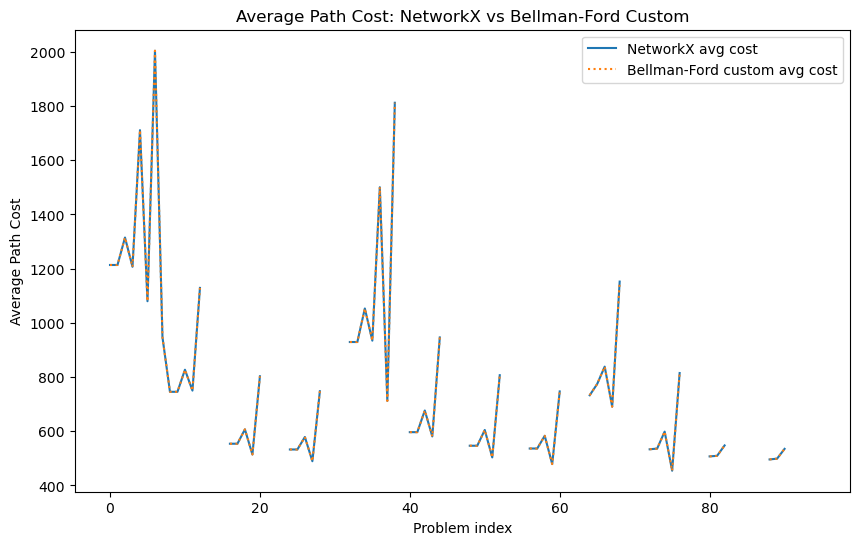

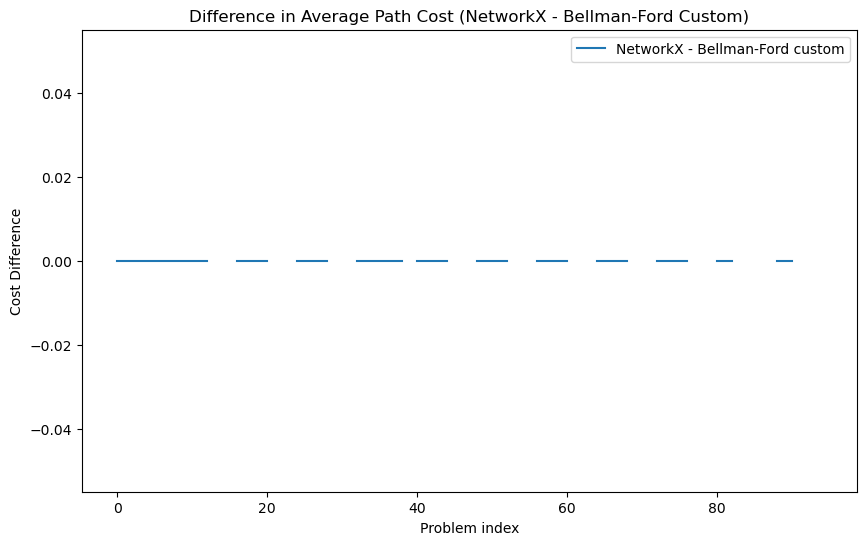

In [23]:
# Load results from file
df_agg = pd.read_csv('result.csv')

# Plot: Average cost comparison
plt.figure(figsize=(10,6))
plt.plot(df_agg['nx_avg'], label='NetworkX avg cost')
plt.plot(df_agg['bellman_ford_avg'], label='Bellman-Ford custom avg cost', linestyle=':')
plt.xlabel('Problem index')
plt.ylabel('Average Path Cost')
plt.title('Average Path Cost: NetworkX vs Bellman-Ford Custom')
plt.legend()
plt.show()

# Plot: Difference between algorithms
plt.figure(figsize=(10,6))
diff = df_agg['nx_avg'] - df_agg['bellman_ford_avg']
plt.plot(diff, label='NetworkX - Bellman-Ford custom')
plt.xlabel('Problem index')
plt.ylabel('Cost Difference')
plt.title('Difference in Average Path Cost (NetworkX - Bellman-Ford Custom)')
plt.legend()
plt.show()